
## <b><span style='color:#686dec'>Введение</span></b>

### Цель

В этом ДЗ вы попрактикуетесь с PyTorch.

### Описание

- Используя PyTorch, создать и обучить регрессионную модель, которая аппроксимирует значение функции **sin(x + 2*y)exp(-(2x + y)^2)** на диапазоне значений **[-10;10] по х и у**
- В качестве обучающей выборки необходимо сгенерировать **20000 точек случайным образом**
- Разделить получившийся датасет на train / test / val в отношениях **70% / 15% / 15%**, соответственно

### Критерии оценки

- (a) Посчитать метрику **Mean Square Error(MSE) на test** (+7 балла за (a))
- (b) Нарисовать график, в котором сравнивается истинная функция и ее аппроксимированный вариант (предсказываемый моделью). +3 балл за (b)

In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.notebook as tqdm


## <b><span style='color:#686dec'>Определение истинной функции</span></b>

> - Используя PyTorch, создать и обучить регрессионную модель, которая аппроксимирует значение функции **sin(x + 2*y)exp(-(2x + y)^2)** на диапазоне значений **[-10;10] по х и у**
> - В качестве обучающей выборки необходимо сгенерировать **20000 точек случайным образом**

In [6]:
# random point [0,1]
x = torch.rand(20000)
y = torch.rand(20000)

# change [-10,10]
x = x * 20 - 10
y = y * 20 - 10
x = x[None,:]; y = y[None,:]
print(x.min(),x.max())
print(y.min(),y.max())

# function
def funct(x,y):
    return torch.sin(x+2*y)*torch.exp(-(2*x+y)**2)

# def funct(x,y):
#     return x**2 + y**2

tensor(-10.0000) tensor(9.9998)
tensor(-9.9984) tensor(9.9999)


In [7]:
z = funct(x,y)

data = torch.concat([x,y,z],dim=0).t()
numpy_data = data.numpy()
df = pd.DataFrame(numpy_data,columns=['x','y','z'])
df

,x,y,z
0,5.907999,-7.999525,2.919641e-07
1,-4.965662,7.948799,-1.959597e-02
2,6.798136,6.879669,0.000000e+00
3,4.882330,-4.780624,1.627852e-11
4,8.118679,-8.338394,-6.093208e-28
...,...,...,...
19995,6.186462,-0.920638,-0.000000e+00
19996,-6.567829,-5.229598,0.000000e+00
19997,8.102180,-8.343935,-1.091805e-27
19998,7.542414,-9.079653,2.025379e-16


## <b><span style='color:#686dec'>Создания подвыборки</span></b>

> - Используя PyTorch, создать и обучить регрессионную модель, которая аппроксимирует значение функции **sin(x + 2*y)exp(-(2x + y)^2)** на диапазоне значений **[-10;10] по х и у**
> - В качестве обучающей выборки необходимо сгенерировать **20000 точек случайным образом**
> Разделить получившийся датасет на train / test / val в отношениях **70% / 15% / 15%**, соответственно

Сначала создаем наш датасет который мы будем использовать:
- В задаче указывается что в обучающей выборке у нас 20000 точек, после чего указывается разбиение; соответственно это можно воспринимать по разному; если train это обучающая выборка то у нас получается (20000,3000,3000)
- Обычно мы создаем датасет, после чего его разбиваем на подвыборки, соответственно это можно и воспринимать как (20000) -> (14000,3000,3000)


In [18]:
''' split data into training,validation & test subsets '''
# Разбиваем выборку на три части 

train, validate, test = np.split(df.sample(frac=1),[int(0.7*len(df)),int(0.85*len(df))])
print(f'train {train.shape[0]/df.shape[0]}')
print(f'validate {validate.shape[0]/df.shape[0]}')
print(f'test {test.shape[0]/df.shape[0]}')

train 0.7
validate 0.15
test 0.15


In [19]:
''' Convert data back into tensor '''
# конвертируем обратно в tensor

train = torch.FloatTensor(train.values)
validate = torch.FloatTensor(validate.values)
test = torch.FloatTensor(test.values)

print(train.size(),validate.size(),test.size())

torch.Size([14000, 3]) torch.Size([3000, 3]) torch.Size([3000, 3])


In [20]:
''' Define x_train, x_val '''
# определяем целевой фичер z и нецелевые фичеры x,y

x_train = train[:,:2]; y_train = train[:,2].squeeze()
x_val = validate[:,:2]; y_val = validate[:,2].squeeze()
x_test = test[:,:2]; y_test = test[:,2].squeeze()

## <b><span style='color:#686dec'>Готовимся к обучению</span></b>

### Определение модели

- Рассматривались разные варианты архитектуры многослойного персептрона, в конечном итоге модель <code>Net</code> показала наилучший результат.
- Архитектура состоит из 5 линейных слоев и 4 функции активации для добавления нелинейности 


In [21]:
''' Define Model '''
# model definition

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_1 = nn.Linear(in_features=2, out_features=100)
        self.act_1 = nn.ReLU()
        self.linear_2 = nn.Linear(in_features=100,out_features=200)
        self.act_2 = nn.ReLU()
        self.linear_3 = nn.Linear(in_features=200,out_features=100)
        self.act_3 = nn.ReLU()
        self.linear_4 = nn.Linear(in_features=100,out_features=50)
        self.act_4 = nn.ReLU()
        self.linear_5 = nn.Linear(in_features=50,out_features=1)

    def forward(self,x):
        x = self.linear_1(x)
        x = self.act_1(x)
        x = self.linear_2(x)
        x= self.act_2(x)
        x = self.linear_3(x)
        x = self.act_3(x)
        x = self.linear_4(x)
        x = self.act_4(x)
        x = self.linear_5(x)
        return x

''' Define device and model '''

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = Net().to(device)

Using cuda device


### Оптимизатор/Функция потерь

Далее в нашей задачи оптимизации весов, нам нужен оптимизатор (Adam) с learning rate 0.0001 и функция потерь (используем MSELoss)

In [24]:
''' Optimiser & Loss Function '''
# определяем оптимизатор и критерии оценки результата

optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.MSELoss()

### Тренируем Модель

В задачи не уточнается что использовать ли валидационный цикл во время обучения или нет, для ускарения тренировки модели, модель не валидируется на выборке val

In [25]:
''' Train model '''
# Тренировочный цикл, используем мини батчи

lst_loss = []; lst_iter = []
for epoch_index in tqdm.tqdm(range(50000)):
    
    x_train = x_train.to(device)
    y_train = y_train.to(device)
     
    # use randomised mini-batch
    ix = torch.randint(0, x_train.shape[0], size=(32,))
    
    optimizer.zero_grad()
    y_pred = model(x_train[ix])
    
    # MSE loss
    loss = criterion(y_pred.squeeze(), y_train[ix])
    
    if(epoch_index % 1000 == 0):
        lst_loss.append(loss.item())
        lst_iter.append(epoch_index)

    optimizer.zero_grad()    
    loss.backward()  
    optimizer.step()

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
sns.set_style("whitegrid", {
            "ytick.major.size": 0.1,
            "ytick.minor.size": 0.05,
            'grid.linestyle': '--'
         })

plt.plot(lst_iter,lst_loss,)
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('история функции потерь')

## <b><span style='color:#686dec'>Визуализация результата</span></b>

### Оценка Модели

Часто мы используем график (y_true vs y_model) для оценки качества регрессионной модели, оценим на всех выборках

In [ ]:
''' Show Prediction vs Truth '''
# функция для сравнения истенных и предсказанные значении

def compare_y(net,x,y,title:str):
    
    sns.set_style("whitegrid", {
            "ytick.major.size": 0.1,
            "ytick.minor.size": 0.05,
            'grid.linestyle': '--'
         })
    
    x = x.to(device)
    y = y.to(device)
    
    # make prediction 
    y_pred = net.forward(x)
    y2 = y_pred.cpu().detach().numpy()[:,0]
    mse_loss = criterion(y_pred.squeeze(), y)
    print(f'mse: {mse_loss}')
       
    plt.plot(y_pred.cpu().detach().numpy(),
             y.cpu().detach().numpy(), 'o', mec='k',ms=5)
    
    plt.legend(loc='upper left')
    plt.xlabel('y_model')
    plt.ylabel('y_true')
    plt.title(title)

mse: 0.0004913838347420096


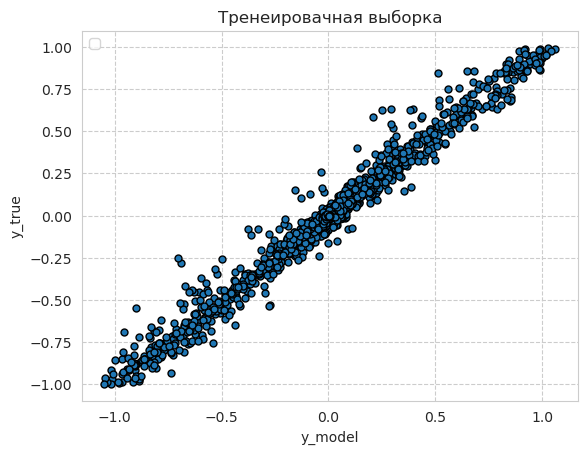

mse: 0.0005845963023602962


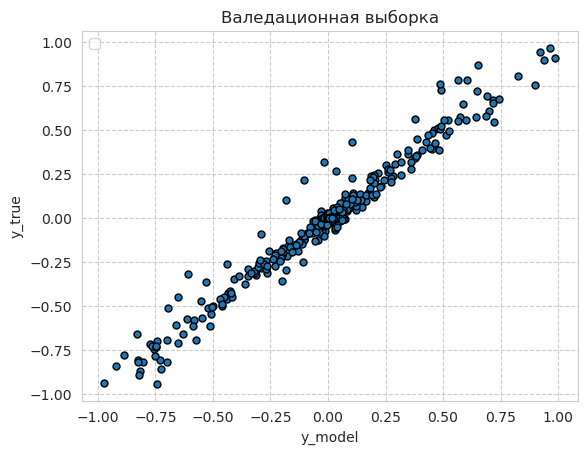

mse: 0.0005324790254235268


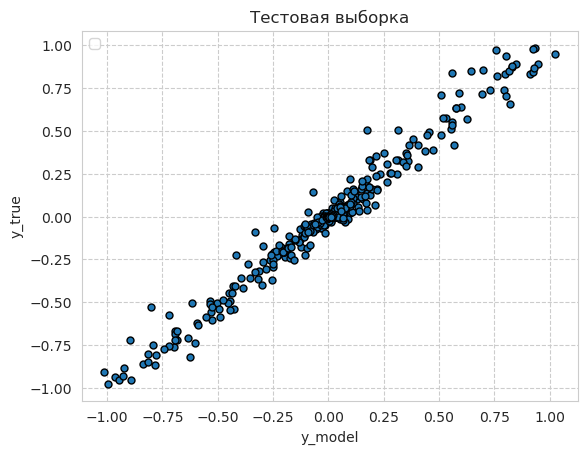

In [39]:
compare_y(model,x_train,y_train,'Тренеировачная выборка'); plt.show()
compare_y(model,x_val,y_val,'Валедационная выборка'); plt.show()
compare_y(model,x_test,y_test,'Тестовая выборка'); plt.show()

### Визуализация Результатов

> Посчитать метрику **Mean Square Error(MSE) на test** <br>
> Нарисовать график, в котором сравнивается истинная функция и ее аппроксимированный вариант (предсказываемый моделью)

Визуализируем результат на всех выборках; на левой стороне у нас истинные значения а на правом графике предсказание модели, мы видим что нейросеть может достаточно хорошо аппроксимировать аналитическую функцию, MSE на тестовой выборке 0.0005324

In [ ]:
''' Show Prediction vs Truth '''
# функция для сравнения истенных и предсказанные значении

from mpl_toolkits.mplot3d import Axes3D  

def compare_pred(net,x,y,title:str):
    
    sns.set_style("whitegrid", {
            "ytick.major.size": 0.1,
            "ytick.minor.size": 0.05,
            'grid.linestyle': '--'
         })
    
    x = x.to(device)
    y = y.to(device)
    
    # create meshgrid
    xg, yg = torch.meshgrid(x[:,0], x[:,0], indexing='xy')
    
    x1 = x[:,0].cpu()
    x2 = x[:,1].cpu()
    y1 = y.cpu()
    
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_trisurf(x1,x2,y1, linewidth=0.0,edgecolors=None,alpha=0.3)
    ax.scatter(x1,x2,y1,edgecolor='black', linewidth=0.5, facecolor=None,s=8)
    ax.view_init(20, 35)
    ax.set_title('Истинные Значения')
    
    # make prediction 
    y_pred = net.forward(x)
    y2 = y_pred.cpu().detach().numpy()[:,0]
    mse_loss = criterion(y_pred.squeeze(), y)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_trisurf(x1,x2,y2, linewidth=0.0,edgecolors=None,alpha=0.3)
    ax.scatter(x1,x2,y2,edgecolor='black', linewidth=0.5, facecolor=None,s=8)
    ax.view_init(20, 35)
    ax.set_title(f'Предсказание Модели')
    plt.suptitle(f'{title} : loss {mse_loss:.4f}')
    plt.show()
    

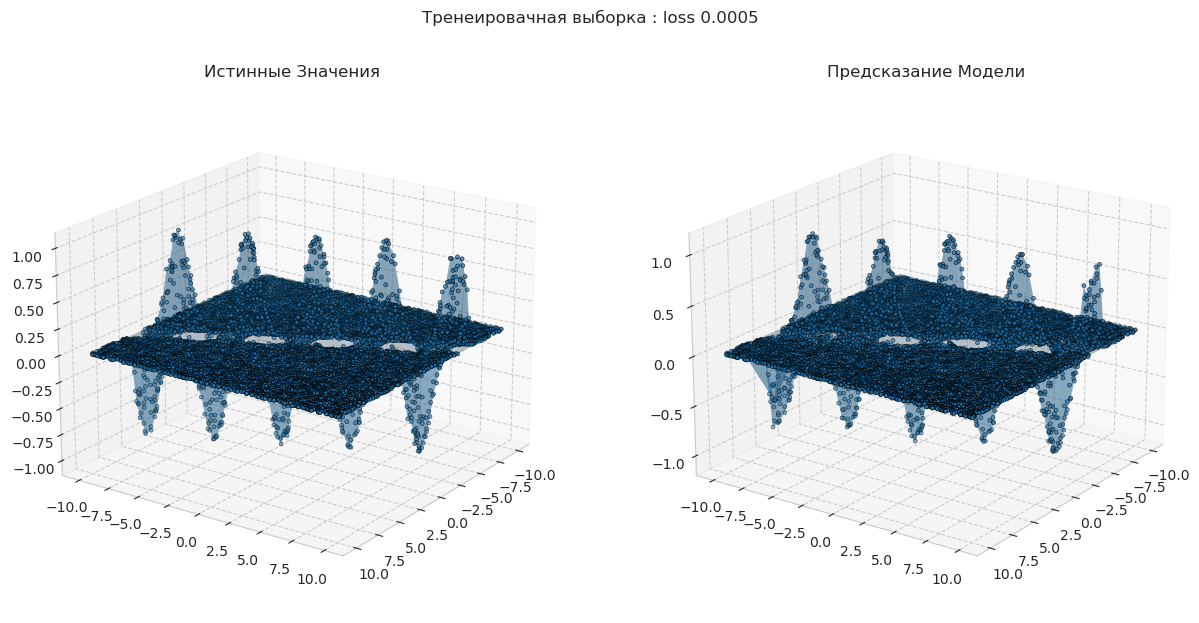

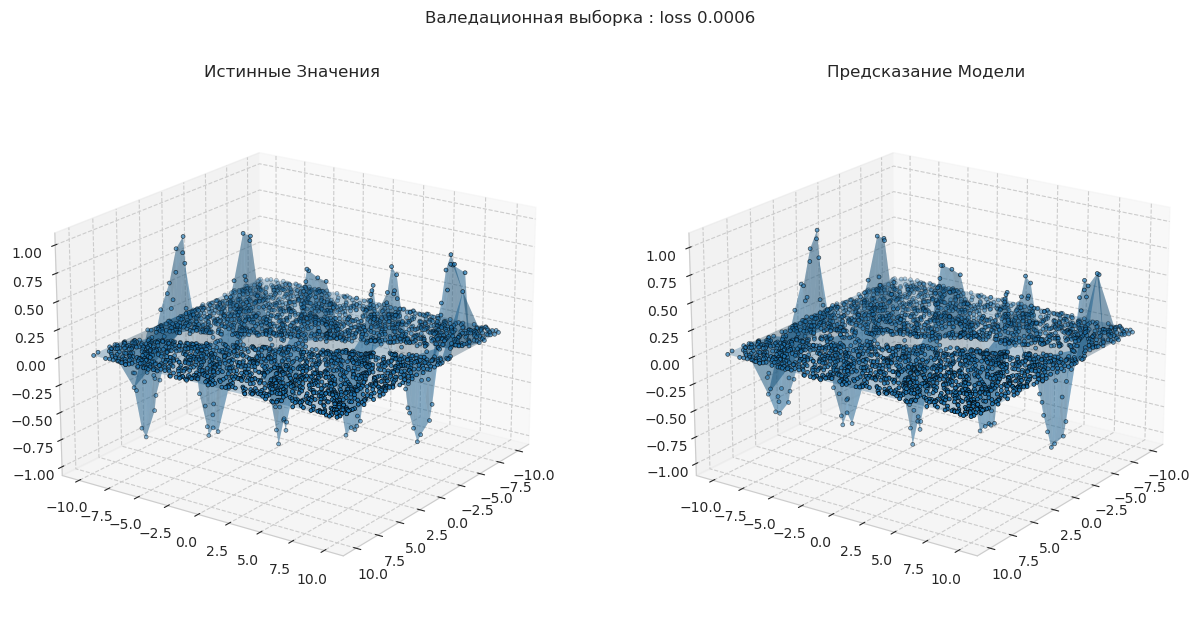

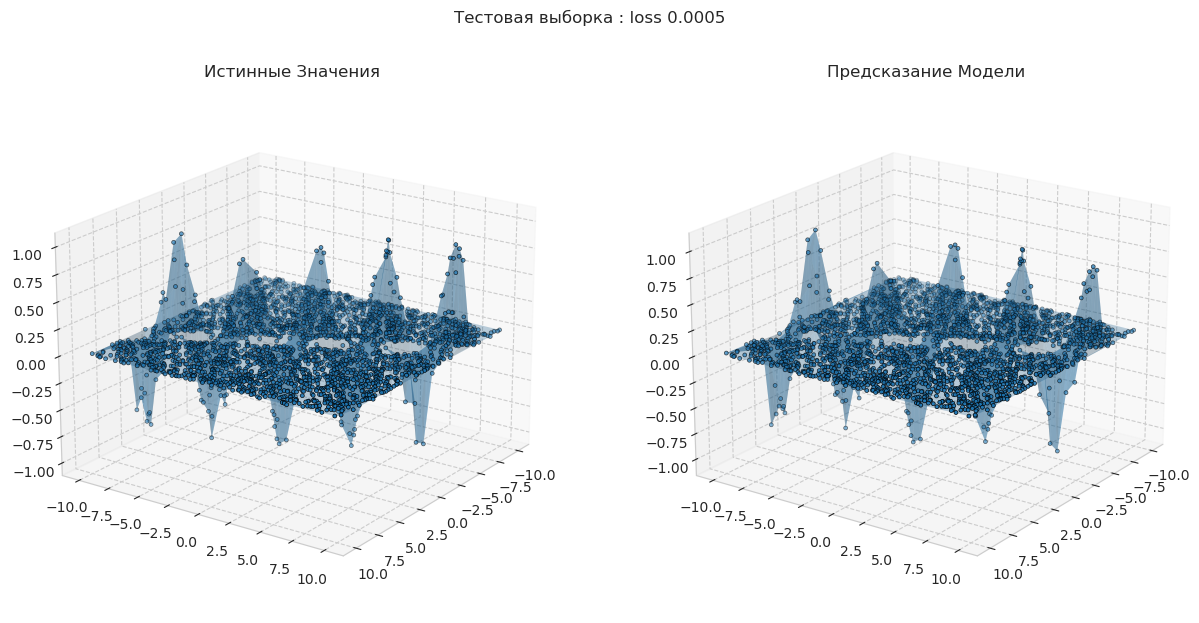

In [29]:
compare_pred(model,x_train,y_train,'Тренеировачная выборка'); plt.show()
compare_pred(model,x_val,y_val,'Валедационная выборка'); plt.show()
compare_pred(model,x_test,y_test,'Тестовая выборка'); plt.show()